# Evaluation of resident time #

Formula to evaluate ideal resident time for 1 reactor
$$ E(t)=\dfrac{1}{\tau}e^{-t/\tau} $$ 

Where $ \tau=\dfrac{Q}{V} $ where $Q$ is the volumetric flow rate and $V$ is the Volume.

Formula to evaluate ideal comulative time
$$ F(t) = 1-e^{-t/\tau} $$

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import glob
import matplotlib.pyplot as plt 

In [2]:
plt.rcParams.update({'font.size' : 16})

### Diameter impact ###
Reading Numerical simualtions files

In [3]:
WorkingDir=r'C:\Users\geron-ma\OneDrive - TUV SUD\Projects-Files\A4I-R10-025_I-Phyc\04_FLUENT\00_RTD_Lights'
#WorkingDir=r'C:\Users\geron-ma\OneDrive - TUV SUD\Projects-Files\A4I-R10-025_I-Phyc\04_FLUENT\Baseline_Geometry'
scenario=r'00_Baseline\00_1phase-water'
baseline='Baseline_Geometry\Baseline'
file_path=os.path.join(WorkingDir,scenario,'*.out')
files=glob.glob(file_path)
Base_file=os.path.join(WorkingDir,scenario,'*.his')
histo_files=glob.glob(Base_file)
#files.append(histo)
#Base_file_avg=os.path.join(WorkingDir,baseline,'RTD-baseline-100.his')
#files.append(Base_file_avg)

In [4]:
files

['C:\\Users\\geron-ma\\OneDrive - TUV SUD\\Projects-Files\\A4I-R10-025_I-Phyc\\04_FLUENT\\00_RTD_Lights\\00_Baseline\\00_1phase-water\\tracer-baseline-outlet.out',
 'C:\\Users\\geron-ma\\OneDrive - TUV SUD\\Projects-Files\\A4I-R10-025_I-Phyc\\04_FLUENT\\00_RTD_Lights\\00_Baseline\\00_1phase-water\\tracer-baseline-pass.out']

In [5]:
data_frames={}  #create dictionary

In [6]:
time_array={}
RTD_array={}
N_particles={}

In [7]:
cases_t = ['Outlet','Sep']
cases_h = ['h-outlet','h-sep']

In [8]:
for file, sim in zip (files, cases_t) :
    data_frames[sim]=pd.read_csv(file, sep='\t', skiprows=1 , names=['iter','E_num','t_num'])
    data_frames[sim]=data_frames[sim].iloc[10:-1,:]
    time_array[sim]=data_frames[sim]['t_num'].to_numpy(dtype='float64')
    RTD_array[sim]=data_frames[sim]['E_num'].to_numpy(dtype='float64')

In [9]:
for file, sim in zip (histo_files, cases_h) :
    data_frames[sim]=pd.read_csv(file, sep=' ', skiprows=11 , names=['t_num','E_num'])
    data_frames[sim]=data_frames[sim].iloc[:-1,:]
    N_particles[sim]=data_frames[sim]['E_num'].sum()
    print(N_particles[sim])
    time_array[sim]=data_frames[sim]['t_num'].to_numpy(dtype='float64')
    RTD_array[sim]=data_frames[sim]['E_num'].to_numpy(dtype='float64')/ N_particles[sim]

3975.0
4031.0


In [10]:
cases=cases_t+cases_h

## Characteristic of the reactor ##

In [11]:
#Q= 0.000347/1020   # m^3/s
Q= 2.31/998
V=3.2*2.5*3.0 # be carefull with units 
tau=V/2/Q
print(tau)

5184.415584415585


In [12]:
t=np.linspace (0, 65000,100)

In [13]:
E_t=(1/tau)*np.exp(-t/tau)

In [14]:
F_t=1-np.exp(-t/tau)

In [15]:
teta=t/tau
E_teta=np.exp(-teta)
E_teta_2=teta*np.exp(-teta)

In [16]:
I0={}
I1={}
tau_num={}

In [17]:
for case in cases:
    I0[case]=sp.integrate.simpson(RTD_array[case],time_array[case],axis=0)
    I1[case]=sp.integrate.simpson(RTD_array[case]*time_array[case],time_array[case],axis=0)
    tau_num[case]=I1[case]/I0[case]
    RTD_array[case]=RTD_array[case]/I0[case]

In [18]:
tau_num

{'Outlet': 11192.413034985799,
 'Sep': 7205.926983792277,
 'h-outlet': 10726.060139635427,
 'h-sep': 6144.141423509766}

In [19]:
I0

{'Outlet': 60.03013930000001,
 'Sep': 46.55826296666667,
 'h-outlet': 1635.1185646834372,
 'h-sep': 1082.664757900852}

## Figure template ##

Define a dictionari for the color and a dictionary for the line stile to be used

In [20]:
col={
    cases[0]:'b',
    cases[1]:'c',
    cases[2]:'g',
    cases[3]:'m',
    #cases[4]:'r'
}
stile={
    cases[0]:'o',
    cases[1]:'s',
    cases[2]:'*',
    cases[3]:'v',
    #cases[4]:'>'
}

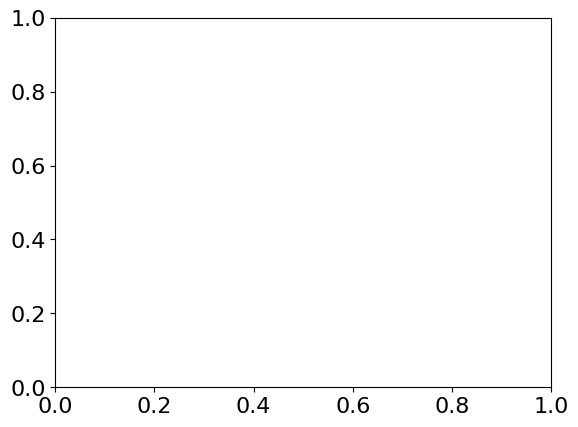

In [21]:
fig, ax = plt.subplots()

In [22]:
plt.ioff()

In [23]:
fig, ax3 = plt.subplots()

In [24]:
ax3.plot(teta, E_t*tau,label='Ideal')
ax3.plot(teta,E_teta_2, label='Ideal-N=2')
for case in cases:
    #ax3.plot(time_array[case]/tau_num[case],RTD_array[case]*tau_num[case],label=case,marker=stile[case],linestyle='--',color=col[case])
    ax3.plot(time_array[case]/tau,RTD_array[case]*tau,label=case,linestyle='--',color=col[case])

In [25]:
ax3.legend()
ax3.set_xlabel(r'$ \theta $')
ax3.set_ylabel(r'E( $ \theta $ )')
ax3.title.set_text('RTD')

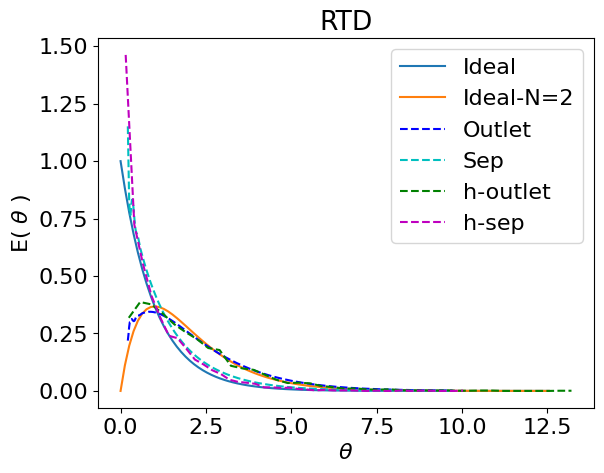

In [26]:
plt.show()

In [27]:
tau_num

{'Outlet': 11192.413034985799,
 'Sep': 7205.926983792277,
 'h-outlet': 10726.060139635427,
 'h-sep': 6144.141423509766}

## Data Fitting ##

In [28]:
def weib(x, c, scale):
    return (c /scale)* (x/scale) **(c - 1) * np.exp(-(x/scale)**c)

In [29]:
cases_100=[cases[0]]
cases_100.append(cases[3])

In [30]:
p , d =sp.optimize.curve_fit(weib,time_array[cases_100[0]]/tau,RTD_array[cases_100[0]]*tau)

In [31]:
pb, d =sp.optimize.curve_fit(weib,time_array[cases_100[1]]/tau,RTD_array[cases_100[1]]*tau)

In [32]:
print("Shape (p):", p)
print("Scale (pb):", pb)

Shape (p): [1.36864016 2.17097572]
Scale (pb): [0.89639406 0.5799062 ]


In [33]:
tetap=np.linspace(0,5,1000)

In [34]:
fig, ax = plt.subplots()

In [35]:
case=cases[1]
ax.plot(time_array[case]/tau,RTD_array[case]*tau,label=case,marker=stile[case],linestyle='--',color=col[case])

In [36]:
case=cases[2]
ax.plot(time_array[case]/tau,RTD_array[case]*tau,label=case,marker=stile[case],linestyle='--',color=col[case])

In [37]:
#ax.plot(time_array['baseline']/tau, weib(time_array['baseline']/tau,p1[0]))
ax.plot(tetap, sp.stats.weibull_min.pdf(tetap,p[0],scale=p[1],loc=0),label='Data-fit-Rotated',color='c')
ax.plot(tetap, sp.stats.weibull_min.pdf(tetap,pb[0],scale=pb[1],loc=0),label='Data-fit-Baseline',color='g')

C:\Users\geron-ma\Portable-software\Anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:2441: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


In [38]:
#ax.plot(tetap, sp.stats.weibull_min.pdf(tetap,1.54,scale=0.87,loc=0))
#ax.plot(tetap, sp.stats.weibull_min.pdf(tetap,1.6161544,scale=1.6161544,loc=0))
#case=cases[3]
#ax.plot(time_array['baseline']/tau, RTD_array['baseline']*tau, label=case,marker=stile[case],linestyle='--',color=col[case])
ax.plot(teta,E_teta_2, label='Ideal-N=2',color='tab:orange')

In [39]:
ax.legend()
ax.set_xlabel(r'$ \theta $')
ax.set_ylabel(r'E( $ \theta $ )')
ax.title.set_text('RTD')

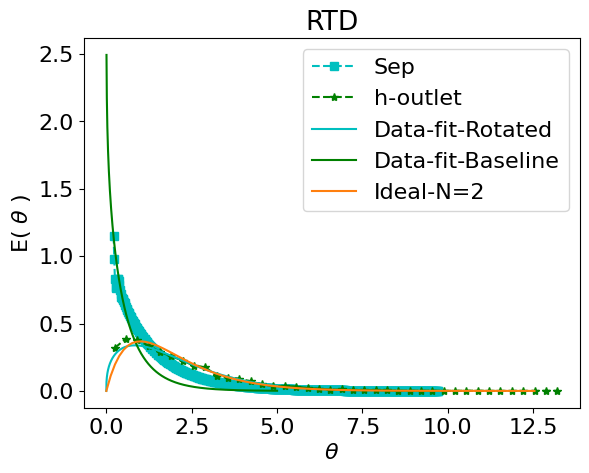

In [40]:
plt.show()

In [41]:
f1=sp.stats.weibull_min.pdf(tetap,p[0],scale=p[1],loc=0)

In [42]:
f2=sp.stats.weibull_min.pdf(tetap,pb[0],scale=pb[1],loc=0)

In [43]:
E_teta_2=tetap*np.exp(-tetap)

In [44]:
def f(t):
    return (sp.stats.weibull_min.pdf(t,p[0],scale=p[1],loc=0)-t*np.exp(-t))
    

In [45]:
int=sp.optimize.fsolve(f, 1.0)

In [46]:
def fb(t):
    return (sp.stats.weibull_min.pdf(t,pb[0],scale=pb[1],loc=0)-t*np.exp(-t))

In [47]:
int_b=sp.optimize.fsolve(fb, 1.0)

In [48]:
print ('baseline inter %2.2f , modified %2.2f' %(int_b,int))

baseline inter 0.85 , modified 0.61


In [49]:
sp.integrate.fixed_quad(fb,0,int_b)

(array([0.54130899]), None)

In [50]:
sp.integrate.fixed_quad(f,0,int)

(array([0.03639575]), None)

In [51]:
def f1(t):
    return (sp.stats.weibull_min.pdf(t,p[0],scale=p[1],loc=0))

In [52]:
sp.integrate.fixed_quad(f1,0,int)

(array([0.16082594]), None)

In [53]:
def f2(t): 
    return (sp.stats.weibull_min.pdf(t,pb[0],scale=pb[1],loc=0))

In [54]:
sp.integrate.fixed_quad(f2,0,int_b)

(array([0.75050879]), None)